In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import gradient_of, rainbow_cmap

# Esta función está modificada de la original en construccion.ipynb
# básicamente el exponente está como 'c' y 'a' está fijo en 2.
# Ademas, puse algunos casos especiales para simplificar el output.
def smoothstep_generator(p: float, s: float):
    """
    Familia de funciones de interpolación suave.
    Devuelve una función de interpolación entre 0 y 1.

    Casos especiales:
    - s = 0: función lineal
    - s = 1: función step centrada en p
    - s = 1, p = 0: constante 1
    - s = 1, p = 1: constante 0

    Parámetros:
    p: Punto de inflexion
    s: Steepness
    """
    if not (0 <= p <= 1) or not (0 <= s <= 1):
        raise ValueError("p and s must be in the range [0,1]")

    if s == 0: # id
        return lambda x: x, lambda x: x

    if s == 1: # step
        slope = lambda x: float('inf')
        match p:
            case 1: return slope, lambda x: 0
            case 0: return slope, lambda x: 1
            case _: return slope, lambda x: 1 if x > p else 0

    c = (2 / (1-s)) - 1

    f = lambda x,n: (x**c) / (n**(c-1))
    g = lambda x,n: (c*x**(c-1)) / (n**(c-1))

    f1 = lambda x: f(x, p)
    f2 = lambda x: 1 - f(1-x, 1-p)
    slope = lambda x: (g(p,p) * (x-p)) + p

    match p:
        case 0: return slope, f1
        case 1: return slope, f2
        case _: return slope, lambda x: (f1 if x <= p else f2)(x)

Dados $s, p \in [0, 1]$, sea $c = \frac{2}{1-s}-1$

Luego, definimos:

$$
f(x,n) = \frac{x^c}{n^{c-1}}
$$

$$
\text{smoothstep}_{s,p}(x)_ = \begin{cases}
    f(x, p) & \text{si } x \leq p \\
    1 - f(1-x, 1-p) & \text{si no}
\end{cases}
$$

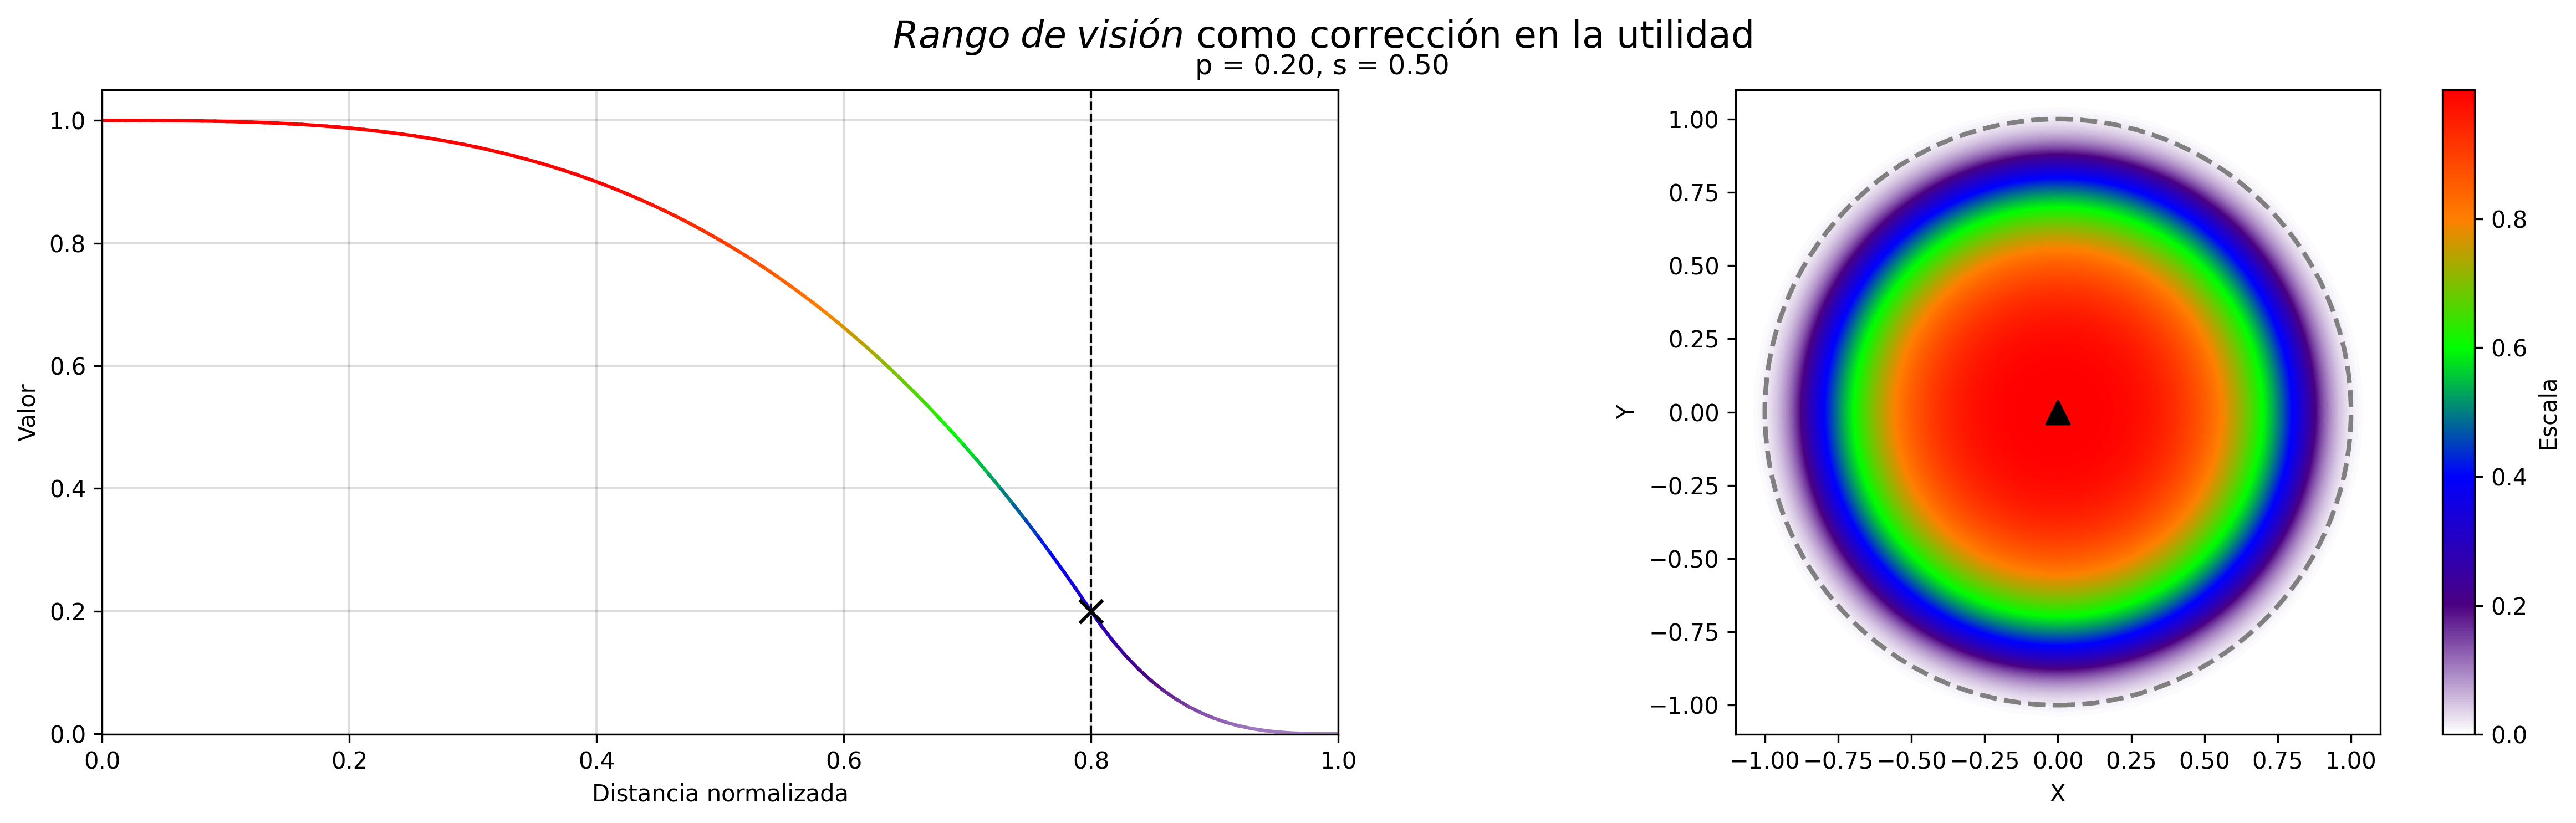

In [2]:
N = 500 # tamaño de la cuadricula
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

inflection, steepness = 1-0.8, .5
s,f = smoothstep_generator(inflection, steepness)
gradient = gradient_of(1-R, f)
gradient = np.where(R <= 1, gradient, np.nan) # filtro para que se vea solo el circulo

# creo la figura con 2 graficos
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=300)

# grafico de la derecha (circulo y gradiente)
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=2)
ax[1].add_artist(circle)

im = ax[1].imshow(gradient, extent=(-1.1, 1.1, -1.1, 1.1), origin='lower', cmap=rainbow_cmap)
fig.colorbar(im, ax=ax[1], label='Escala')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_facecolor('white')
ax[1].scatter(0, 0, color='black', marker='^', s=100, zorder=3)

xs = np.linspace(0, 1, 100)
ys = np.array(list(map(lambda x: f(1-x), xs)))

_ys = ys.copy()
_ys = _ys.astype(np.float64)
_ys += 0.1
colors = rainbow_cmap(_ys)

# grafico de la izquierda (funcion)
ax[0].axvline(1-inflection, color='black', linestyle='--', linewidth=1, zorder=1) # linea vertical en ((1-p), (1-p))
ax[0].scatter(1-inflection, f(inflection), color='black', marker='x', s=100, zorder=3) # punto en ((1-p), f(p))

# grafico de la funcion, pintandola según el valor de 'y'
for i in range(len(xs) - 1):
    ax[0].plot(xs[i:i+2], ys[i:i+2], color=colors[i])

ax[0].grid(True, color='#202020', linestyle='-', linewidth=1, alpha=0.15)
ax[0].set_xlabel('Distancia normalizada')
ax[0].set_ylabel('Valor')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(-0.001, 1.05)

fig.suptitle('$Rango\;de\;visión$ como corrección en la utilidad', fontsize=16)
fig.text(0.5, 0.92, f'p = {inflection:.2f}, s = {steepness:.2f}', ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig(f'./smoothstep_{inflection:.2f}_{steepness:.2f}.png')
plt.show()